# **TCC - REGRESSÃO LOGÍSTICA E REDES NEURAIS RECORRENTES PARA A CLASSIFICAÇÃO DE DISCURSOS DE ÓDIO NO TWITTER DURANTE A CAMPANHA ELEITORAL.**

Emanuel Martins Lourençon - 180281

Luiza Helena Camargo - 171162

#[1] Tweepy

[1.1] Instalação da biblioteca e autenticação

In [ ]:
pip install git+https://github.com/tweepy/tweepy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tweepy/tweepy.git to /tmp/pip-req-build-6r9irmff
  Running command git clone -q https://github.com/tweepy/tweepy.git /tmp/pip-req-build-6r9irmff


In [ ]:
import tweepy as tw
import numpy as np

auth = tw.Client('AAAAAAAAAAAAAAAAAAAAAADggAEAAAAAF7qw1V8UXCQd1ZcaHwMI0KBHpNo%3DVnJiql2SAFr5cxFmuYVOsJsrgoxcaFRBVMbswBpDWKnSvkYnqd')

[1.2] Coletando tweets por palavras chaves

In [ ]:
result = []
for tweet in tw.Paginator(auth.search_recent_tweets, query='lula ladrao lang:pt -has:media',  start_time='2022-10-12T00:00:00Z', end_time='2022-10-12T23:59:59Z',
                              tweet_fields=['lang','created_at','possibly_sensitive'], max_results=100).flatten(limit=200):
  result.append(tweet)

[1.3] Coletando tweets por usuário

In [ ]:
# Buscando ID dos usuários
result = auth.get_user(username='nikolas_dm')
result

In [ ]:
result = []
for tweet in tw.Paginator(auth.get_users_tweets,id=758264276, start_time='2022-08-16T00:00:00Z', end_time='2022-10-15T23:59:59Z',
                               tweet_fields=['lang','created_at','possibly_sensitive'], max_results=100).flatten(limit=3200):
 result.append(tweet)

[1.4] Separando as colunas e exibindo

In [ ]:
import pandas as pd
df = pd.DataFrame()

colunas = [
    'id',
    'text',
    'created_at',
    'lang',
    'possibly_sensitive',
]

df = pd.DataFrame(result,columns=colunas)
df.head()

,id,text,created_at,lang,possibly_sensitive
0,1580347558148595712,"LULA NO COMPLEXO DO ALEMÃO-RJ, 12/10/2022\n\nF...",2022-10-12 23:59:53+00:00,pt,False
1,1580347474967158785,RT @FranciscaBadar1: Uma pergunta para Ciro e ...,2022-10-12 23:59:34+00:00,pt,False
2,1580347470780846080,RT @nikolas_dm: O TSE pediu pra eu retirar o ...,2022-10-12 23:59:33+00:00,pt,False
3,1580347459867328512,"Pai revoltado ,indignado , pede para quem vota...",2022-10-12 23:59:30+00:00,pt,False
4,1580347447033102339,@brom_elisa Lula ladrão ladrão ladrão ladrão l...,2022-10-12 23:59:27+00:00,pt,False


[1.5] Salvando o arquivo em .csv separando as colunas por |

In [ ]:
file = 'fascismo_06.csv'
df.to_csv(file, encoding='utf-8', index=False, sep='|')

# [2] Pré-processamentos

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import tokenize

def preprocessamento(texto, hasLanguage=True):
  texto["text"] = texto["text"].replace(to_replace = "@[A-Za-z0-9_]*", value = "", regex = True) #Remover o @ dos usuários do tweet
  texto["text"] = texto["text"].replace(to_replace = "\\n", value = " ", regex = True) #Remover o \n do texto
  texto["text"] = texto["text"].replace(to_replace = "'", value = "", regex = True) #Remover '' das palavras
  texto["text"] = texto["text"].replace(to_replace = "http[^ ]+", value = "", regex = True) #Remover links
  texto["text"] = texto["text"].replace(to_replace = "www.[^ ]+", value = "", regex = True) #Remover links
  texto["text"] = texto["text"].replace(to_replace = "^RT ", value = "", regex = True) #Remover a palavra RT
  texto["text"] = texto["text"].replace(to_replace = "#[^ ]+ ", value = "", regex = True) #Remover #
  
  #if hasLanguage:
  #  texto = texto.drop_duplicates()
  #  texto = texto[texto['lang'] == 'pt'] #Remover tweets que não forem em português

  #Remover palavras irrelevantes sem pontuação

  nltk.download('stopwords')

  palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
  frase_processada = list()

  token_espaco = tokenize.WhitespaceTokenizer()

  for tweet in texto['text']:
      nova_frase = list()
      palavras_texto = token_espaco.tokenize(tweet)
      for palavra in palavras_texto:
          if palavra not in palavras_irrelevantes:
              nova_frase.append(palavra)
      frase_processada.append(' '.join(nova_frase))
      
  texto["tratamento_1"] = frase_processada

  #Remover palavras irrelevantes com pontuação

  from string import punctuation

  pontuacao = list()
  for ponto in punctuation:
      pontuacao.append(ponto)

  pontuacao_stopwords = pontuacao + palavras_irrelevantes
  token_pontuacao = tokenize.WordPunctTokenizer()

  frase_processada = list()
  for opiniao in texto["tratamento_1"]:
      nova_frase = list()
      palavras_texto = token_pontuacao.tokenize(opiniao)
      for palavra in palavras_texto:
          if palavra not in pontuacao_stopwords:
              nova_frase.append(palavra)
      frase_processada.append(' '.join(nova_frase))
      
  texto["tratamento_2"] = frase_processada

  #Remover os acentos de todas as palavras da base e filtro das palavras irrelevantes sem acento

  !pip install unidecode
  import unidecode

  sem_acentos = [unidecode.unidecode(texto) for texto in texto["tratamento_2"]]
  stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

  texto["tratamento_3"] = sem_acentos

  frase_processada = list()
  for opiniao in texto["tratamento_3"]:
      nova_frase = list()
      palavras_texto = token_pontuacao.tokenize(opiniao)
      for palavra in palavras_texto:
          if palavra not in stopwords_sem_acento:
              nova_frase.append(palavra)
      frase_processada.append(' '.join(nova_frase))
      
  texto["tratamento_3"] = frase_processada

  #Transformar a base toda em minúsculo

  frase_processada = list()
  for opiniao in texto["tratamento_3"]:
      nova_frase = list()
      opiniao = opiniao.lower()
      palavras_texto = token_pontuacao.tokenize(opiniao)
      for palavra in palavras_texto:
          if palavra not in stopwords_sem_acento:
              nova_frase.append(palavra)
      frase_processada.append(' '.join(nova_frase))
      
  texto["tratamento_4"] = frase_processada

  #Normalizar as palavras

  nltk.download('rslp')
  stemmer = nltk.RSLPStemmer()

  frase_processada = list()
  for opiniao in texto["tratamento_4"]:
      nova_frase = list()
      palavras_texto = token_pontuacao.tokenize(opiniao)
      for palavra in palavras_texto:
          if palavra not in stopwords_sem_acento:
              nova_frase.append(stemmer.stem(palavra))
      frase_processada.append(' '.join(nova_frase))
      
  texto["tratamento_5"] = frase_processada

#[3] Carregando a base de discurso de ódio e as bases dos candidatos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#Carregar as bases
tweets = pd.read_csv("drive/MyDrive/Colab_Datasets/todos-2.txt", sep="|")
odio = pd.read_csv("drive/MyDrive/Colab_Datasets/odio_2.csv")
lula = pd.read_csv("drive/MyDrive/Colab_Datasets/lula.csv", sep="|")
boulos = pd.read_csv("drive/MyDrive/Colab_Datasets/boulos.csv", sep="|")
bolsonaro = pd.read_csv("drive/MyDrive/Colab_Datasets/bolsonaro.csv", sep="|")
nikolas = pd.read_csv("drive/MyDrive/Colab_Datasets/nikolas.csv", sep="|")

#Pre-procesamento das bases
preprocessamento(tweets)
preprocessamento(odio, False)
preprocessamento(lula)
preprocessamento(bolsonamro)
preprocessamento(nikolas)
preprocessamento(boulos)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 18.7 MB/s 


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
print("Quantidade da base de tweets: ", len(tweets))
print("Quantidade da base de Ódio: ", len(odio))
print("Quantidade da base do Boulos: ", len(boulos))
print("Quantidade da base do Bolsonaro: ", len(bolsonaro))
print("Quantidade da base do Nikolas: ", len(nikolas))
print("Quantidade da base do Lula: ", len(lula))

Quantidade da base de tweets:  36375
Quantidade da base de Ódio:  5670
Quantidade da base do Boulos:  1352
Quantidade da base do Bolsonaro:  564
Quantidade da base do Nikolas:  701
Quantidade da base do Lula:  1443


In [ ]:
result = odio[odio.hatespeech_comb == 1]
result


,text,hatespeech_comb,hatespeech_G1,annotator_G1,hatespeech_G2,annotator_G2,hatespeech_G3,annotator_G3,tratamento_1,tratamento_2,tratamento_3,tratamento_4,tratamento_5
0,O cara vive em outro mundo Não no mundo real...,1,1,A,1.0,V,0,E,O cara vive outro mundo Não mundo real REFUGIA...,O cara vive outro mundo Não mundo real REFUGIA...,O cara vive outro mundo Nao mundo real REFUGIA...,cara vive outro mundo mundo real refugiados vi...,car viv outr mund mund real refugi viv favel v...
4,bom dia macaco branco haha,1,0,A,1.0,I,1,E,bom dia macaco branco haha,bom dia macaco branco haha,bom dia macaco branco haha,bom dia macaco branco haha,bom dia macac branc hah
17,Perfume pra mão jovem amante.....pra mão. Cap...,1,1,D,1.0,It,0,E,Perfume pra mão jovem amante.....pra mão. Capp...,Perfume pra mão jovem amante ..... pra mão Cap...,Perfume pra mao jovem amante ..... pra mao Cap...,perfume pra mao jovem amante ..... pra mao cap...,perfum pra mao jov am ..... pra mao capp
18,Estimo que se foda será mais profissional.,1,1,D,0.0,B,1,B,Estimo foda profissional.,Estimo foda profissional,Estimo foda profissional,estimo foda profissional,est fod profiss
19,bom dia sapatao da minha vida,1,1,A,1.0,Dani,1,C,bom dia sapatao vida,bom dia sapatao vida,bom dia sapatao vida,bom dia sapatao vida,bom dia sapata vid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655,O Islão não é uma religião como as outras.É u...,1,1,E,1.0,V,0,D,O Islão religião outras.É doutrina totalitária...,O Islão religião outras É doutrina totalitária...,O Islao religiao outras E doutrina totalitaria...,islao religiao outras doutrina totalitaria lit...,isla religia outr doutrin totalit liter escrit...
5661,Tô esperando a sapatão fazer,1,1,D,1.0,It,1,C,Tô esperando sapatão fazer,Tô esperando sapatão fazer,To esperando sapatao fazer,to esperando sapatao fazer,to esper sapata faz
5666,"sei das cotas, mas não sabia disso, putaria d...",1,1,D,1.0,It,0,A,"sei cotas, sabia disso, putaria porra",sei cotas sabia disso putaria porra,sei cotas sabia disso putaria porra,sei cotas sabia disso putaria porra,sei cot sab diss put porr
5668,"seguir no tt é facíl, apresentar as amigas sa...",1,1,C,1.0,S,0,A,"seguir tt facíl, apresentar amigas sapatão ngm...",seguir tt facíl apresentar amigas sapatão ngm ...,seguir tt facil apresentar amigas sapatao ngm ...,seguir tt facil apresentar amigas sapatao ngm ...,segu tt facil apresent amig sapata ngm qu kkkkkk


# [4] Classificação e vetorização com TF-IDF e regressão logística


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def classificar_texto_tfidf(texto, coluna_texto, coluna_classificacao, hasResultados, texto_teste=list()):
    tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,1))

    tfidf_bruto = tfidf.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto,
                                                              texto[coluna_classificacao],
                                                              train_size=0.7,
                                                              random_state = 42,
                                                              stratify=texto[coluna_classificacao])
   
    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)

    predict_result = []
    if hasResultados:
      predict_result = regressao_logistica.predict(teste)
    else:
      tfidf_tweets = tfidf.transform(texto_teste['tratamento_5'])
      predict_result = regressao_logistica.predict(tfidf_tweets)

    if hasResultados:
      matriz_confusao = confusion_matrix(classe_teste, predict_result)
      print('Verdadeiro negativo %f' % matriz_confusao[0][0])
      print('Falso negativo %f' % matriz_confusao[0][1])
      print('Falso positivo %f' % matriz_confusao[1][0])
      print('Verdadeiro positivo %f' % matriz_confusao[1][1])
      print(matriz_confusao)
      print(classification_report(classe_teste, predict_result))
      return []

    return predict_result

In [ ]:
classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', True)

Verdadeiro negativo 1118.000000
Falso negativo 47.000000
Falso positivo 375.000000
Verdadeiro positivo 162.000000
[[1118   47]
 [ 375  162]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1165
           1       0.78      0.30      0.43       537

    accuracy                           0.75      1702
   macro avg       0.76      0.63      0.64      1702
weighted avg       0.76      0.75      0.71      1702



[]

In [ ]:
#Predição para a base de tweets da campanha eleitoral (total)
predict_result_tweets = classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', False, tweets)
tweets['classificacao'] = predict_result_tweets

#Predição para a base de tweets do Lula
predict_result_lula = classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', False, lula)
lula['classificacao'] = predict_result_lula

#Predição para a base de tweets do Bolsonaro
predict_result_bolsonaro = classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', False, bolsonaro)
bolsonaro['classificacao'] = predict_result_bolsonaro

#Predição para a base de tweets do Boulos
predict_result_boulos = classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', False, boulos)
boulos['classificacao'] = predict_result_boulos

#Predição para a base de tweets do Nikolas
predict_result_nikolas = classificar_texto_tfidf(odio, 'tratamento_5', 'hatespeech_comb', False, nikolas)
nikolas['classificacao'] = predict_result_nikolas

In [ ]:
resultado = tweets[tweets.classificacao == 1]
len(resultado)

327

In [ ]:
resultado = lula[lula.classificacao == 1]
len(resultado)

4

In [ ]:
resultado = bolsonaro[bolsonaro.classificacao == 1]
len(resultado)

2

In [ ]:
resultado = boulos[boulos.classificacao == 1]
len(resultado)

3

In [ ]:
resultado = nikolas[nikolas.classificacao == 1]
len(resultado)

7

#[5] Classificação e vetorização com Word Embedding e regressão logística


In [ ]:
!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip

--2022-11-06 18:47:07--  http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348388454 (332M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fglove%2Fglove_s100.zip’

download.php?file=e 100%[===================>] 332.25M  11.2MB/s    in 30s     

2022-11-06 18:47:37 (10.9 MB/s) - ‘download.php?file=embeddings%2Fglove%2Fglove_s100.zip’ saved [348388454/348388454]



In [ ]:
!unzip glove_s100.zip

Archive:  glove_s100.zip
  inflating: glove_s100.txt          


In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def classificar_texto_w2v(texto, coluna_texto, coluna_classificacao, hasResultados, texto_teste=[]):
  modelo = KeyedVectors.load_word2vec_format('glove_s100.txt')

  sentencas = []
  for s in texto[coluna_texto]:
    vetor = []
    for p in s.split():
      if p in modelo.wv:
        vetor.append(modelo.wv[p])
    embedding = np.array(vetor).mean(axis=0)
    if embedding.shape != (100,):
      embedding = np.zeros((100,))
    sentencas.append(embedding)

  sentencas = np.array(sentencas)

  treino, teste, classe_treino, classe_teste = train_test_split(sentencas,
                                                            texto[coluna_classificacao],
                                                            train_size=0.7,
                                                            random_state = 42,
                                                            stratify=texto[coluna_classificacao])
  print("teste y: ", sum(classe_teste) / len(teste))
  print("treino y: ", + sum(classe_treino) / len(treino))

  sentencas_teste = []
  if hasResultados == False:
    for s in texto_teste[coluna_texto]:
      vetor = []
      for p in s.split():
        if p in modelo.wv:
          vetor.append(modelo.wv[p])
      embedding = np.array(vetor).mean(axis=0)
      if embedding.shape != (100,):
        embedding = np.zeros((100,))
      sentencas_teste.append(embedding)
    sentencas_teste = np.array(sentencas_teste)

  regressao_logistica = LogisticRegression(solver = "lbfgs", max_iter=200)
  regressao_logistica.fit(treino, classe_treino)
  predict_result = []
  
  if hasResultados:
    predict_result = regressao_logistica.predict(teste)
  else:
    predict_result = regressao_logistica.predict(sentencas_teste)

  if hasResultados:
    matriz_confusao = confusion_matrix(classe_teste, predict_result)
    print('Verdadeiro negativo %f' % matriz_confusao[0][0])
    print('Falso negativo %f' % matriz_confusao[0][1])
    print('Falso positivo %f' % matriz_confusao[1][0])
    print('Verdadeiro positivo %f' % matriz_confusao[1][1])
    print(matriz_confusao)
    print(classification_report(classe_teste, predict_result))

  return predict_result

In [ ]:
predict = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


teste y:  0.31551116333725027
treino y:  0.3152721774193548
Verdadeiro negativo 1065.000000
Falso negativo 100.000000
Falso positivo 371.000000
Verdadeiro positivo 166.000000
[[1065  100]
 [ 371  166]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1165
           1       0.62      0.31      0.41       537

    accuracy                           0.72      1702
   macro avg       0.68      0.61      0.62      1702
weighted avg       0.70      0.72      0.69      1702



In [ ]:
#Predição para a base de tweets da campanha eleitoral
predict_result_tweets = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', False, tweets)
tweets['classificacao'] = predict_result_tweets

#Predição para a base de tweets do Lula
predict_result_lula = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', False, lula)
lula['classificacao'] = predict_result_lula

#Predição para a base de tweets do Bolsonaro
predict_result_bolsonaro = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', False, bolsonaro)
bolsonaro['classificacao'] = predict_result_bolsonaro

#Predição para a base de tweets do Boulos
predict_result_boulos = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', False, boulos)
boulos['classificacao'] = predict_result_boulos

#Predição para a base de tweets do Nikolas
predict_result_nikolas = classificar_texto_w2v(odio, 'tratamento_4', 'hatespeech_comb', False, nikolas)
nikolas['classificacao'] = predict_result_nikolas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


teste y:  0.31551116333725027
treino y:  0.3152721774193548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWa

teste y:  0.31551116333725027
treino y:  0.3152721774193548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWa

teste y:  0.31551116333725027
treino y:  0.3152721774193548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWa

teste y:  0.31551116333725027
treino y:  0.3152721774193548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWa

teste y:  0.31551116333725027
treino y:  0.3152721774193548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
resultado = tweets[tweets.classificacao == 1]
len(resultado)

1209

In [ ]:
resultado = nikolas[nikolas.classificacao == 1]
len(resultado)

37

In [ ]:
resultado = boulos[boulos.classificacao == 1]
len(resultado)

20

In [ ]:
resultado = lula[lula.classificacao == 1]
len(resultado)

10

In [ ]:
resultado = bolsonaro[bolsonaro.classificacao == 1]
len(resultado)

4

#[6] Classificação e vetorização com Word Embedding e redes neurais recorrentes

In [ ]:
import numpy as np

filepath = "glove_s100.txt"

embeddings_index = {}
with open(filepath) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Total de vetores encontrados: %i." % len(embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  if __name__ == '__main__':


Total de vetores encontrados: 929594.


In [ ]:
treino, teste, classe_treino, classe_teste = train_test_split(odio['tratamento_4'],
                                                            odio['hatespeech_comb'],
                                                            train_size=0.7,
                                                            random_state = 42,
                                                            stratify=odio['hatespeech_comb'])

In [ ]:
count = 0

for tweet in odio['tratamento_4']:
  count += len(tweet.split())
avg_words = int(count / len(odio)) + 1

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

vectorizer = TextVectorization(max_tokens=5000, output_sequence_length=avg_words)
ds = tf.data.Dataset.from_tensor_slices(treino).batch(128)
vectorizer.adapt(ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None and embedding_vector.shape == (100,):
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Palavras obtidas %d e perdidas %d" % (hits, misses))

Palavras obtidas 4673 e perdidas 327


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype="string"),  
    vectorizer,
    embedding_layer,
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 9)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 9, 100)            500200    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 585,331
Trainable params: 85,131
Non-tra

In [ ]:
history = model.fit(treino, classe_treino, batch_size=128, epochs=7, validation_data=(teste, classe_teste))

Epoch 1/7
31/31 [==============================] - 8s 75ms/step - loss: 0.6130 - accuracy: 0.6935 - val_loss: 0.5697 - val_accuracy: 0.7168
Epoch 2/7
31/31 [==============================] - 1s 39ms/step - loss: 0.5602 - accuracy: 0.7188 - val_loss: 0.5538 - val_accuracy: 0.7309
Epoch 3/7
31/31 [==============================] - 1s 39ms/step - loss: 0.5363 - accuracy: 0.7402 - val_loss: 0.5496 - val_accuracy: 0.7268
Epoch 4/7
31/31 [==============================] - 1s 39ms/step - loss: 0.5242 - accuracy: 0.7440 - val_loss: 0.5514 - val_accuracy: 0.7280
Epoch 5/7
31/31 [==============================] - 1s 39ms/step - loss: 0.5091 - accuracy: 0.7528 - val_loss: 0.5464 - val_accuracy: 0.7338
Epoch 6/7
31/31 [==============================] - 1s 39ms/step - loss: 0.4936 - accuracy: 0.7649 - val_loss: 0.5476 - val_accuracy: 0.7297
Epoch 7/7
31/31 [==============================] - 1s 38ms/step - loss: 0.4761 - accuracy: 0.7752 - val_loss: 0.5503 - val_accuracy: 0.7297


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)


def plot_acc(history):
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

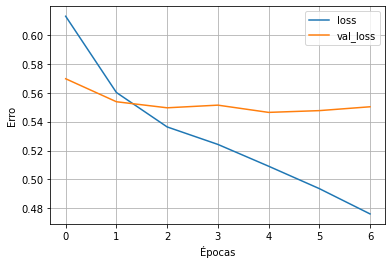

In [ ]:
plot_loss(history)

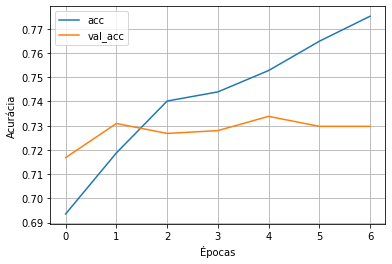

In [ ]:
plot_acc(history)

In [ ]:
def generate_result(predict_result):
  result = []
  for item in predict_result:
    if item >= 0.5:
      result.append(1)
    else:
      result.append(0)
  return result

In [ ]:
predict_result = model.predict(tweets['tratamento_4'])
tweets['classificacao'] = generate_result(predict_result)

1137/1137 [==============================] - 7s 5ms/step


In [ ]:
predict_result = model.predict(boulos['tratamento_4'])
boulos['classificacao'] = generate_result(predict_result)

43/43 [==============================] - 0s 5ms/step


In [ ]:
predict_result = model.predict(bolsonaro['tratamento_4'])
bolsonaro['classificacao'] = generate_result(predict_result)

18/18 [==============================] - 0s 6ms/step


In [ ]:
predict_result = model.predict(lula['tratamento_4'])
lula['classificacao'] = generate_result(predict_result)

46/46 [==============================] - 0s 5ms/step


In [ ]:
predict_result = model.predict(nikolas['tratamento_4'])
nikolas['classificacao'] = generate_result(predict_result)

22/22 [==============================] - 0s 6ms/step


In [ ]:
print("Discursos de ódio identificados para a base de tweets: ", len(tweets[tweets['classificacao'] == 1]))
print("Discursos de ódio identificados para a base do Lula: ", len(lula[lula['classificacao'] == 1]))
print("Discursos de ódio identificados para a base do Boulos: ",len(boulos[boulos['classificacao'] == 1]))
print("Discursos de ódio identificados para a base do Bolsonaro: ", len(bolsonaro[bolsonaro['classificacao'] == 1]))
print("Discursos de ódio identificados para a base do Nikolas: ", len(nikolas[nikolas['classificacao'] == 1]))

Discursos de ódio identificados para a base de tweets:  4315
Discursos de ódio identificados para a base do Lula:  84
Discursos de ódio identificados para a base do Boulos:  40
Discursos de ódio identificados para a base do Bolsonaro:  11
Discursos de ódio identificados para a base do Nikolas:  39
